# **Can we predict customer waiting time based on order and restaurant characteristics?**

 **Disclaimer**

The dataset was obtained from an online public source which is currently unavailable.

The data is used strictly for educational and non-commercial purposes.

In [52]:
import pandas as pd
path = "/content/food_order.csv" #Path to csv file
df = pd.read_csv(path)

## **1.Exploratory Data Analysis (EDA)**

**Objective:**
Predict total customer waiting time using information available at order placement.


> **Target:** total_wait_time = food_preparation_time + delivery_time

In [53]:
df['total_wait_time'] = df['food_preparation_time'] + df['delivery_time']
df = df.drop(columns=['food_preparation_time', 'delivery_time'])

### Data overview

In [54]:
df.shape

(1898, 8)

In [55]:
df.head()

,order_id,customer_id,restaurant_name,cuisine_type,cost_of_the_order,day_of_the_week,rating,total_wait_time
0,1477147,337525,Hangawi,Korean,30.75,Weekend,Not given,45
1,1477685,358141,Blue Ribbon Sushi Izakaya,Japanese,12.08,Weekend,Not given,48
2,1477070,66393,Cafe Habana,Mexican,12.23,Weekday,5,51
3,1477334,106968,Blue Ribbon Fried Chicken,American,29.20,Weekend,3,40
4,1478249,76942,Dirty Bird to Go,American,11.59,Weekday,4,49


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1898 entries, 0 to 1897
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   order_id           1898 non-null   int64  
 1   customer_id        1898 non-null   int64  
 2   restaurant_name    1898 non-null   object 
 3   cuisine_type       1898 non-null   object 
 4   cost_of_the_order  1898 non-null   float64
 5   day_of_the_week    1898 non-null   object 
 6   rating             1898 non-null   object 
 7   total_wait_time    1898 non-null   int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 118.8+ KB


**The dataset consists of 1,898 records with 10 columns. The variable rating is an only post-event outcome. And apart from the target, the only numerical feature is order cost, while all other features are categorical.**

### Data quality check

NaN check

In [57]:
df.isna().sum()

,0
order_id,0
customer_id,0
restaurant_name,0
cuisine_type,0
cost_of_the_order,0
day_of_the_week,0
rating,0
total_wait_time,0


Non integer check

In [58]:
import pandas as pd

temp_df = df.copy()
non_numeric_counts = {}

for column in temp_df.columns:
    # Change non numeric to NaN
    converted_column = pd.to_numeric(temp_df[column], errors='coerce')
    non_numeric_count = converted_column.isna().sum()
    non_numeric_counts[column] = non_numeric_count

# NaN Count
non_numeric_df = pd.DataFrame(non_numeric_counts.items(), columns=['Column', 'Non-Numeric Count'])
display(non_numeric_df)

,Column,Non-Numeric Count
0,order_id,0
1,customer_id,0
2,restaurant_name,1898
3,cuisine_type,1898
4,cost_of_the_order,0
5,day_of_the_week,1898
6,rating,736
7,total_wait_time,0


### Univariate Analysis

**Pre-event variable**

In [59]:
df['restaurant_name'].value_counts()

,count
restaurant_name,
Shake Shack,219
The Meatball Shop,132
Blue Ribbon Sushi,119
Blue Ribbon Fried Chicken,96
Parm,68
...,...
Rye House,1
Hiroko's Place,1
Frank Restaurant,1


In [60]:
df['cuisine_type'].value_counts()

,count
cuisine_type,
American,584
Japanese,470
Italian,298
Chinese,215
Mexican,77
Indian,73
Middle Eastern,49
Mediterranean,46
Thai,19


In [61]:
df['day_of_the_week'].value_counts()

,count
day_of_the_week,
Weekend,1351
Weekday,547


**cuisine_type and day_of_the_week features exhibit low to moderate(2-14) cardinality, making them suitable for encoding and modeling. While restaurant name appear to have high cardinality compare to record we have (178 to 1,898 record)**

In [62]:
df['cost_of_the_order'].describe() #usd

,cost_of_the_order
count,1898.000000
mean,16.498851
std,7.483812
min,4.470000
25%,12.080000
50%,14.140000
75%,22.297500
max,35.410000


<Axes: >

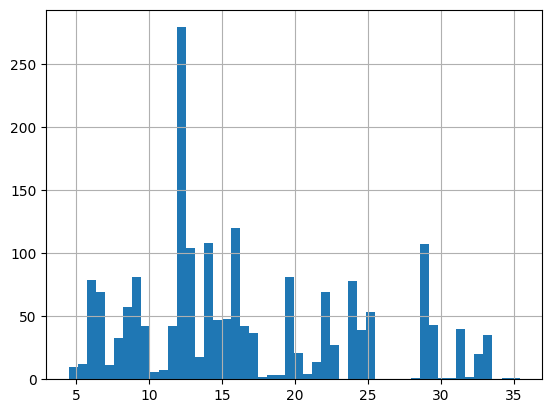

In [63]:
df['cost_of_the_order'].hist(bins=50)

**The distribution of cost_of_the_order is right-skewed, with most orders concentrated around 10–20 USD. The mean and median values indicate that the majority of orders are moderately priced, no extreme outliers are observed.**

**Post-event variable**

In [64]:
df['rating'].value_counts()

,count
rating,
Not given,736
5,588
4,386
3,188


**Around 50% of rating are not given and potential
 leakage behavior of Rating variable suggesting we might not use Rating as a core feature.**

**Target variable**

In [65]:
df['total_wait_time'].describe()

,total_wait_time
count,1898.000000
mean,51.533720
std,6.833603
min,35.000000
25%,47.000000
50%,52.000000
75%,56.000000
max,68.000000


<Axes: >

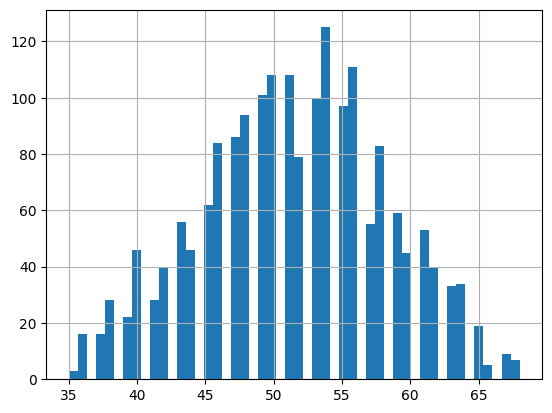

In [66]:
df['total_wait_time'].hist(bins=50)

In [67]:
df['total_wait_time'].quantile([0.01, 0.99])

,total_wait_time
0.01,36.97
0.99,66.00


**The distribution of 'total_wait_time' appears approximately normal, with most orders delivered within 45–60 minutes. Based on the observed quantiles, no extreme outliers are present in the dataset.**

### Multivariate Analysis

In [68]:
df.groupby('day_of_the_week')['total_wait_time'].mean()

,total_wait_time
day_of_the_week,
Weekday,55.552102
Weekend,49.906736


<Axes: title={'center': 'total_wait_time'}, xlabel='day_of_the_week'>

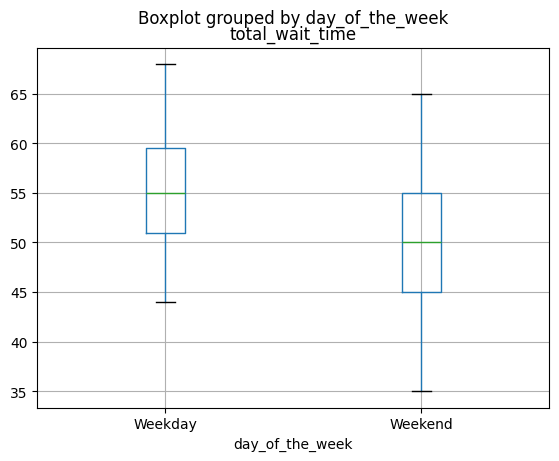

In [69]:
df.boxplot(column='total_wait_time', by='day_of_the_week')

**Despite a larger volume of orders on weekends (1351 vs 547 record), total waiting time is lower compared to weekdays.
Weekend orders show higher variability, where weekday delivery times are more stable but consistently longer.**

In [70]:
df['cost_bucket'] = pd.qcut(df['cost_of_the_order'], 4)
df.groupby('cost_bucket')['total_wait_time'].mean()

/tmp/ipython-input-3295092974.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('cost_bucket')['total_wait_time'].mean()


,total_wait_time
cost_bucket,
"(4.468999999999999, 12.08]",51.252049
"(12.08, 14.14]",51.498915
"(14.14, 22.298]",51.757384
"(22.298, 35.41]",51.633684


<Axes: title={'center': 'total_wait_time'}, xlabel='cost_bucket'>

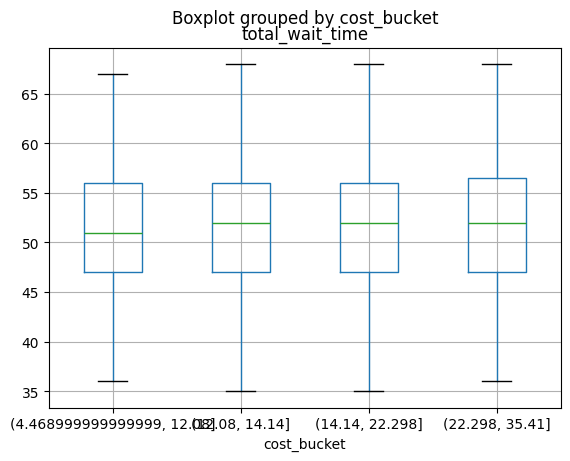

In [71]:
df.boxplot(column='total_wait_time', by='cost_bucket')

**The average total waiting time remains relatively constant across all cost buckets  at around 51–52 minutes, suggesting that order price alone is not a strong predictor of waiting time.**

**This indicates that operational factors may have a greater impact than order value. However, further analysis is still required to examine potential interaction effects with other variables.**

<Axes: xlabel='cuisine_type'>

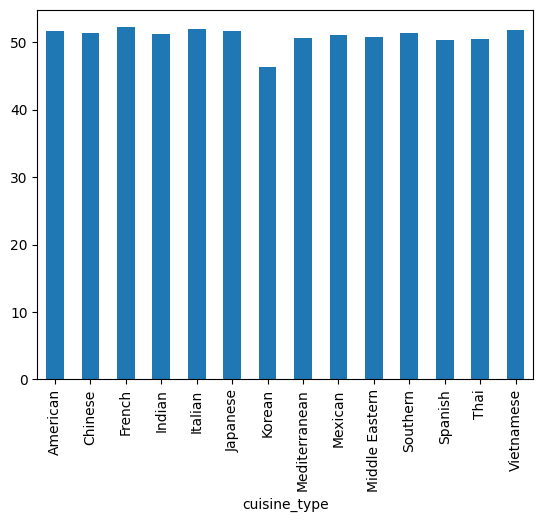

In [72]:
df.groupby('cuisine_type')['total_wait_time'].mean().plot(kind='bar')

<Axes: title={'center': 'total_wait_time'}, xlabel='cuisine_type'>

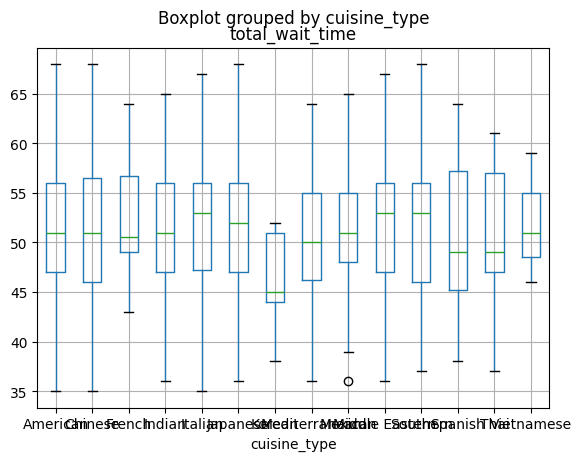

In [73]:
df.boxplot(column='total_wait_time', by='cuisine_type')

**While mean waiting times are similar across cuisines, variability differs noticeably.
Some cuisines demonstrate more consistent delivery times, indicating potential operational differences.**

<Axes: xlabel='cuisine_type'>

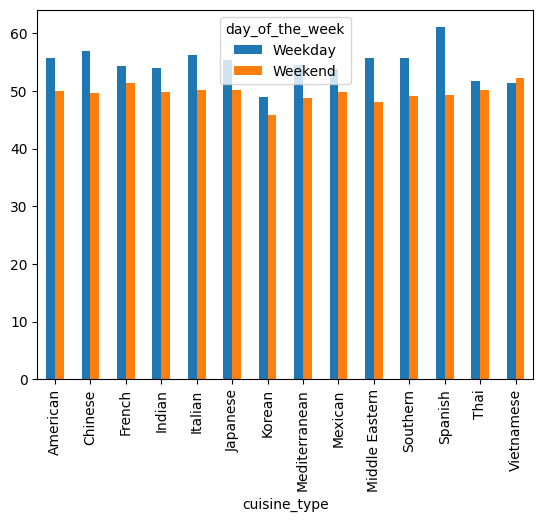

In [74]:
df.groupby(['cuisine_type', 'day_of_the_week'])['total_wait_time'].mean().unstack().plot(kind='bar')

**Weekday orders are consistently slower across all cuisine types, with minor variations in the amount of delay by cuisine.**

### **EDA Summary**

**1. Target Variable: Total Waiting Time**

The target variable, total_wait_time, follows an approximately normal distribution with a mean of around 51–52 minutes.
Most orders are delivered within the range of 45–60 minutes, and no extreme outliers are observed.
This suggests that the target variable is suitable for regression modeling without the need for major transformations.

**2. Order Cost Analysis**

The distribution of cost_of_the_order is right-skewed, with most orders concentrated around lower price ranges (10-20 USD).
However, exploratory analysis using cost quartiles shows that the average waiting time remains relatively stable across different order values.

This indicates that order cost alone is not a strong predictor of delivery time, although it may still contribute through interactions with other variables.

**3. Day of the Week Effect**

Orders placed on weekdays consistently exhibit longer waiting times compared to weekends.
Despite weekends having a significantly larger number of orders, average delivery times are shorter and more variable.

This suggests that operational factors such as rider availability or scheduling efficiency may differ between weekdays and weekends, making day_of_the_week an important predictive feature.

**4. Cuisine Type Analysis**

Average waiting times across different cuisine types are generally similar.
However, variability differs across cuisines, with certain cuisines showing more consistent delivery times than others.

Some cuisines also exhibit different magnitudes of weekday–weekend delay, indicating a potential interaction effect between cuisine_type and day_of_the_week.

**5. Key Insights and Feature Implications**

	•	day_of_the_week is a strong and consistent predictor of delivery time.
	•	cuisine_type may not significantly shift the average waiting time but contributes to variability and interaction effects.
	•	cost_of_the_order shows limited standalone predictive power but may still be useful in combination with other features.
	•	No severe data quality issues or leakage indicators were detected during EDA.

**6. Next Steps**

Based on the exploratory analysis, the following features are selected for baseline modeling:

	•	day_of_the_week
	•	cuisine_type
	•	cost_of_the_order

The next phase will focus on feature encoding and training baseline regression models to quantify feature importance and predictive performance.

##**2. Baseline Modeling**

**Prepare Data For Modeling**

**X  = Feature**

**y = Target**

In [75]:
X = df[['day_of_the_week', 'cuisine_type', 'cost_of_the_order']]
y = df['total_wait_time']

**One-hot Encoding**

In [76]:
X['day_of_the_week'] = X['day_of_the_week'].map({
    'Weekday': 0,
    'Weekend': 1
})

/tmp/ipython-input-156603063.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['day_of_the_week'] = X['day_of_the_week'].map({


In [77]:
if 'cuisine_type' in X.columns:
    X = pd.get_dummies(X, columns=['cuisine_type'], drop_first=True)
X.head()

,day_of_the_week,cost_of_the_order,cuisine_type_Chinese,cuisine_type_French,cuisine_type_Indian,cuisine_type_Italian,cuisine_type_Japanese,cuisine_type_Korean,cuisine_type_Mediterranean,cuisine_type_Mexican,cuisine_type_Middle Eastern,cuisine_type_Southern,cuisine_type_Spanish,cuisine_type_Thai,cuisine_type_Vietnamese
0,1,30.75,False,False,False,False,False,True,False,False,False,False,False,False,False
1,1,12.08,False,False,False,False,True,False,False,False,False,False,False,False,False
2,0,12.23,False,False,False,False,False,False,False,True,False,False,False,False,False
3,1,29.20,False,False,False,False,False,False,False,False,False,False,False,False,False
4,0,11.59,False,False,False,False,False,False,False,False,False,False,False,False,False


**Train-test split**

In [78]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

**Mean Baseline**

In [79]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_baseline = np.full_like(y_test, y_train.mean())
mae_baseline = mean_absolute_error(y_test, y_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_baseline))

mae_baseline, rmse_baseline

(5.686842105263158, np.float64(6.933708660556317))

##**3. Linear Regression Model**

**Training**

In [80]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

**Predict on test set**

In [81]:
y_pred_lr = lr.predict(X_test)

**Evaluate Model**

In [82]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

mae_lr, rmse_lr

(5.340327458555132, np.float64(6.439426343770188))

In [83]:
coef_df = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': lr.coef_
})

coef_df

,feature,coefficient
0,day_of_the_week,-5.748754
1,cost_of_the_order,0.011629
2,cuisine_type_Chinese,-0.042916
3,cuisine_type_French,0.668840
4,cuisine_type_Indian,-1.060426
5,cuisine_type_Italian,0.282877
6,cuisine_type_Japanese,0.153887
7,cuisine_type_Korean,-4.115633
8,cuisine_type_Mediterranean,-0.742288
9,cuisine_type_Mexican,-0.387556


**A baseline Linear Regression model was trained and evaluated against a naive mean predictor.
The linear model achieved lower MAE and RMSE, indicating that the selected features contain predictive signal.**

**Day of the week is the most influential feature, with weekend orders being significantly faster than weekday orders.
Cuisine type contributes moderate effects, while order cost shows the least impact on waiting time.**

## **4.Decision Tree model**

In [84]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

dt = DecisionTreeRegressor(
    max_depth=5,
    min_samples_leaf=30,
    random_state=42
)

dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)

mae_dt = mean_absolute_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))

mae_dt, rmse_dt

(5.451249793701797, np.float64(6.559624506277579))

**Hyperparameters were manually constrained to reduce overfitting rather than optimized at this stage.**

**min_samples_leaf=30 (~1.5% of data)**

**max depth = 5**

In [85]:
pd.DataFrame({
    'model': ['Mean baseline', 'Linear Regression', 'Decision Tree'],
    'MAE': [mae_baseline, mae_lr, mae_dt],
    'RMSE': [rmse_baseline, rmse_lr, rmse_dt]
})

,model,MAE,RMSE
0,Mean baseline,5.686842,6.933709
1,Linear Regression,5.340327,6.439426
2,Decision Tree,5.451250,6.559625


**Decision Tree was introduced to capture non-linear relationships.**
- Regularization was applied to prevent overfitting.
- Performance was comparable but not superior to linear regression.
- This motivated the use of ensemble methods.

## **5.Random forest model**

**Baseline Random Forest**

In [86]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

rf = RandomForestRegressor(
    n_estimators=200,        # จำนวนต้นไม้
    max_depth=8,             # จำกัดความลึก
    min_samples_leaf=20,     # ลด overfitting
    random_state=42,
    n_jobs=-1                # ใช้ทุก core
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

mae_rf, rmse_rf

(5.421300242863401, np.float64(6.489879116380181))

**Hyperparameters were manually constrained to balance bias and variance.**

In [87]:
result_df = pd.DataFrame({
    'model': [
        'Mean baseline',
        'Linear Regression',
        'Decision Tree',
        'Random Forest'
    ],
    'MAE': [
        mae_baseline,
        mae_lr,
        mae_dt,
        mae_rf
    ],
    'RMSE': [
        rmse_baseline,
        rmse_lr,
        rmse_dt,
        rmse_rf
    ]
})

result_df

,model,MAE,RMSE
0,Mean baseline,5.686842,6.933709
1,Linear Regression,5.340327,6.439426
2,Decision Tree,5.451250,6.559625
3,Random Forest,5.421300,6.489879


**Despite Random Forest being a more flexible model, it did not outperform Linear Regression, indicating that the underlying relationship is largely linear and feature-limited. So, we're trying feature engineering one last time.**

In [88]:
feat_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

feat_imp

,feature,importance
0,day_of_the_week,0.645289
1,cost_of_the_order,0.304813
5,cuisine_type_Italian,0.020556
6,cuisine_type_Japanese,0.016569
2,cuisine_type_Chinese,0.011977
9,cuisine_type_Mexican,0.000463
4,cuisine_type_Indian,0.000199
8,cuisine_type_Mediterranean,0.000132
3,cuisine_type_French,0.000000
7,cuisine_type_Korean,0.000000


## **6.Feature engineering**

### Log Transform

**From EDA, One information we know is that the feature 'cost_of_the_order' is right-skew, suggesting that log transform might make the model using this feature better**

####Training

In [89]:
df['log_cost_of_the_order'] = np.log1p(df['cost_of_the_order'])

In [90]:
X = df[['day_of_the_week', 'cuisine_type', 'log_cost_of_the_order']].copy()
y = df['total_wait_time']

X['day_of_the_week'] = X['day_of_the_week'].map({
    'Weekday': 0,
    'Weekend': 1
})

X = pd.get_dummies(X, columns=['cuisine_type'], drop_first=True)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Linear Regression

In [91]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

lr_log = LinearRegression()
lr_log.fit(X_train, y_train)

y_pred_log = lr_log.predict(X_test)

mae_log = mean_absolute_error(y_test, y_pred_log)
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))

mae_log, rmse_log

(5.339667212480179, np.float64(6.438665451842936))

Decision Tree

In [92]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

dt = DecisionTreeRegressor(
    max_depth=5,
    min_samples_leaf=30,
    random_state=42
)

dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)

mae_dt_log = mean_absolute_error(y_test, y_pred_dt)
rmse_dt_log = np.sqrt(mean_squared_error(y_test, y_pred_dt))

mae_dt_log, rmse_dt_log

(5.451249793701797, np.float64(6.559624506277579))

Random Forest

In [93]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

rf = RandomForestRegressor(
    n_estimators=200,        # จำนวนต้นไม้
    max_depth=8,             # จำกัดความลึก
    min_samples_leaf=20,     # ลด overfitting
    random_state=42,
    n_jobs=-1                # ใช้ทุก core
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

mae_rf_log = mean_absolute_error(y_test, y_pred_rf)
rmse_rf_log = np.sqrt(mean_squared_error(y_test, y_pred_rf))

mae_rf_log, rmse_rf_log

(5.422047209698329, np.float64(6.490900692735624))

#### **Summary**

In [94]:
result_df = pd.DataFrame({
    'model': [
        'Mean baseline',
        'Linear Regression (raw cost)',
        'Linear Regression (log cost)',
        'Decision Tree (raw cost)',
        'Decision Tree (log cost)',
        'Random Forest (raw cost)',
        'Random Forest (log cost)'
    ],
    'MAE': [
        mae_baseline,
        mae_lr,
        mae_log,
        mae_dt,
        mae_dt_log,
        mae_rf,
        mae_rf_log
    ],
    'RMSE': [
        rmse_baseline,
        rmse_lr,
        rmse_log,
        rmse_dt,
        rmse_dt_log,
        rmse_rf,
        rmse_rf_log
    ]
})

result_df

,model,MAE,RMSE
0,Mean baseline,5.686842,6.933709
1,Linear Regression (raw cost),5.340327,6.439426
2,Linear Regression (log cost),5.339667,6.438665
3,Decision Tree (raw cost),5.451250,6.559625
4,Decision Tree (log cost),5.451250,6.559625
5,Random Forest (raw cost),5.421300,6.489879
6,Random Forest (log cost),5.422047,6.490901


**Very few change between before and after of log transform suggesting this transform might not really essential to waiting time**

### Feature interaction

#### Training

In [95]:
X_train_fe = X_train.copy()
X_test_fe = X_test.copy()

In [96]:
X = df[['day_of_the_week', 'cuisine_type', 'cost_of_the_order']].copy()
y = df['total_wait_time']

X['day_of_the_week'] = X['day_of_the_week'].map({
    'Weekday': 0,
    'Weekend': 1
})

X = pd.get_dummies(X, columns=['cuisine_type'], drop_first=True)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train_fe = X_train.copy()
X_test_fe = X_test.copy()

Cuisine x Weekend interaction

In [97]:
cuisine_cols = [c for c in X_train.columns if c.startswith('cuisine_type_')]

for col in cuisine_cols:
    X_train_fe[f'{col}_weekend'] = X_train_fe[col] * X_train_fe['day_of_the_week']
    X_test_fe[f'{col}_weekend'] = X_test_fe[col] * X_test_fe['day_of_the_week']

Cost x Weekend interaction

In [98]:
X_train_fe['cost_weekend'] = (
    X_train_fe['cost_of_the_order'] * X_train_fe['day_of_the_week']
)
X_test_fe['cost_weekend'] = (
    X_test_fe['cost_of_the_order'] * X_test_fe['day_of_the_week']
)

In [99]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

lr_fe = LinearRegression()
lr_fe.fit(X_train_fe, y_train)

y_pred_lr_fe = lr_fe.predict(X_test_fe)

mae_lr_fe = mean_absolute_error(y_test, y_pred_lr_fe)
rmse_lr_fe = np.sqrt(mean_squared_error(y_test, y_pred_lr_fe))

mae_lr_fe, rmse_lr_fe

(5.36740116307546, np.float64(6.46993338191451))

In [100]:
from sklearn.ensemble import RandomForestRegressor

rf_fe = RandomForestRegressor(
    n_estimators=300,
    max_depth=8,
    min_samples_leaf=10,
    random_state=42
)

rf_fe.fit(X_train_fe, y_train)

y_pred_rf_fe = rf_fe.predict(X_test_fe)

mae_rf_fe = mean_absolute_error(y_test, y_pred_rf_fe)
rmse_rf_fe = np.sqrt(mean_squared_error(y_test, y_pred_rf_fe))

mae_rf_fe, rmse_rf_fe

(5.483765938655879, np.float64(6.531061760358765))

#### **Summary**

In [101]:
result_df = pd.DataFrame({
    'model': [
        'Mean baseline',
        'Linear Regression',
        'Linear Regression + interaction',
        'Random Forest',
        'Random Forest + interaction'
    ],
    'MAE': [
        mae_baseline,
        mae_lr,
        mae_lr_fe,
        mae_rf,
        mae_rf_fe
    ],
    'RMSE': [
        rmse_baseline,
        rmse_lr,
        rmse_lr_fe,
        rmse_rf,
        rmse_rf_fe
    ]
})

result_df

,model,MAE,RMSE
0,Mean baseline,5.686842,6.933709
1,Linear Regression,5.340327,6.439426
2,Linear Regression + interaction,5.367401,6.469933
3,Random Forest,5.421300,6.489879
4,Random Forest + interaction,5.483766,6.531062


**Adding the interaction feature result in worse performance suggesting the feature signal is really weak and adding more noise and variance to the model**

 ### **Despite testing non-linear models and interaction features, the linear regression model remained the best-performing approach, suggesting that delivery wait time is largely driven by additive effects.**

## **7.Validation**

**Linear regression was selected due to its performance, simplicity,
and interpretability better to more complex models we test.**

### Cross validation

In [102]:
from sklearn.model_selection import cross_val_score

cv_mae = -cross_val_score(
    lr,
    X_train,
    y_train,
    scoring='neg_mean_absolute_error',
    cv=5
)

cv_mae.mean(), cv_mae.std()

(np.float64(5.212166879362188), np.float64(0.25279656737591333))

**The model achieves an average MAE of around 5.2 minutes with low variance across folds,
indicating stable and reliable performance.**

### Residual Analysis

Text(0, 0.5, 'Residual')

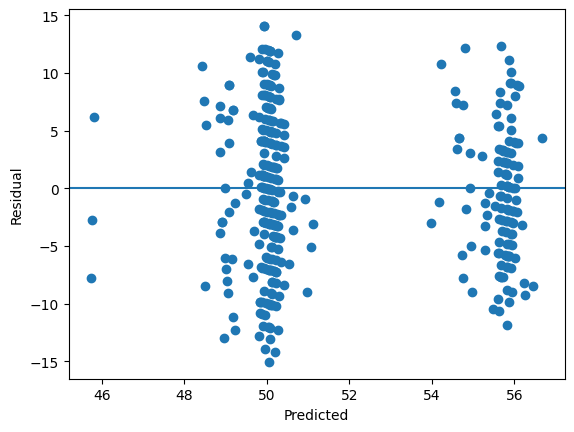

In [103]:
import matplotlib.pyplot as plt

residuals = y_test - y_pred_lr

plt.scatter(y_pred_lr, residuals)
plt.axhline(0)
plt.xlabel("Predicted")
plt.ylabel("Residual")

**Residual analysis shows no systematic pattern, suggesting that the linear regression model is well-specified.
However, the clustered predictions indicate limited feature granularity, which constrains further performance improvements.**

## **8.Conclusion**

**Approach**

We began with a structured Exploratory Data Analysis (EDA) to understand data distributions, detect anomalies, and assess relationships between features and the target variable.

The analysis showed that Weekend/Weekdays is one of the strongest feature to total_wait_time.

Baseline Mean Model is built to use as a reference point to evaluate more complex model.

**Model Performance**

Among all tested models, Linear Regression achieved the best overall performance, with an MAE of approximately 5.3 minutes, outperforming both tree-based models.

More complex models such as Decision Tree and Random Forest did not yield better results, suggesting that the underlying relationships in the data are largely linear and that the available features provide limited additional nonlinear signal.

**Validation**

Cross-validation results further confirmed that the linear model is stable and reliable, with low variance across folds.

Residual analysis also showed no systematic patterns or strong heteroscedasticity, indicating that the linear model assumptions are reasonably satisfied.

**What Was Tried and Why It Did Not Improve Performance**

- Log transformation of order cost did not significantly improve model performance, indicating a weak relationship between order price and waiting time.
- Interaction features increased model complexity without reducing error, likely due to limited signal in the original features.
- Tree-based models underperformed, suggesting insufficient feature richness rather than underfitting or hyperparameter issues.

**What I learned?**

Overall, this project help me learning a complete and well-structured machine learning workflow, from EDA, cutting the leakage feature and baseline modeling to evaluation and interpretation.
The results show the importance of aligning model complexity with data characteristics and that the meaningful performance gains often come from better features rather than more complex models.